# Hotel review keyword extraction

In this project, we explore different methods of keyword extraction from hotel reviews. The project aims to extract important keywords from the reviews to gain insights, categorize feedback, and improve customer understanding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict
import yake
from rake_nltk import Rake

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict

nltk.download('punkt')
nltk.download('stopwords')

from keybert import KeyBERT
from rouge import Rouge

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\israe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\israe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# import the data
reviews_data = pd.read_csv('/Users/israe/Downloads/Hotel_Reviews_Booking.csv')
reviews_data = reviews_data[:1000]

### Prepare the reveiws dataset
pos_df = reviews_data.loc[:, ['Positive_Review']].copy()
pos_df.columns = ['Review']
pos_df.loc[:, 'Positive'] = 1

neg_df = reviews_data.loc[:, ['Negative_Review']].copy()
neg_df.columns = ['Review']
neg_df.loc[:, 'Positive'] = 1

clf_df = pd.concat([pos_df,neg_df])
clf_df = clf_df.drop_duplicates().reset_index(drop=True)
clf_df

,Review,Positive
0,Only the park outside of the hotel was beauti...,1
1,No real complaints the hotel was great great ...,1
2,Location was good and staff were ok It is cut...,1
3,Great location in nice surroundings the bar a...,1
4,Amazing location and building Romantic setting,1
...,...,...
1654,More seating in the bar area would be good al...,1
1655,The cleaner knocked on our door at 8am which ...,1
1656,This was my second time at this hotel the fir...,1
1657,Going as a family with two rooms hired in the...,1


In [3]:
def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove special characters
    text = re.sub(r'[^A-Za-z\s]', '', text)
    return text

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

clf_df['Cleaned_Review'] = clf_df['Review'].apply(clean_text)
clf_df['Cleaned_Review'] = clf_df['Cleaned_Review'].apply(remove_stop_words)

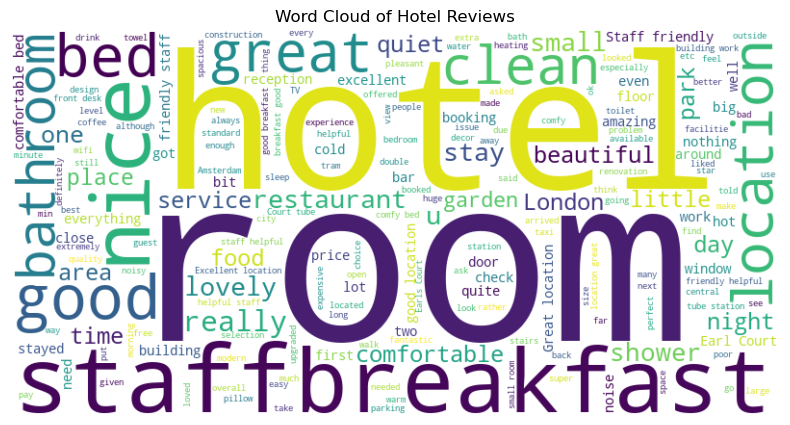

In [4]:
# Visualize word cloud
all_words = ' '.join(clf_df['Cleaned_Review']).split()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hotel Reviews')
plt.show()

### Tf-idf

Tf-idf identifies words that are both frequent within a specific review (term frequency) and relatively rare across all the reviews (inverse document frequency).

In [5]:
# Perform Tf-idf
vectorizer = TfidfVectorizer(stop_words=set(stopwords.words('english')))
tfidf_matrix = vectorizer.fit_transform(clf_df['Cleaned_Review'])

# Get the feature names (keywords)
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)
keywords_df = pd.DataFrame({'Keyword': feature_names, 'Importance': tfidf_scores})

# Insret the keywords to list
keywords_df = keywords_df.sort_values(by='Importance', ascending=False)
tfidf_keywords = keywords_df['Keyword'].tolist()

### YAKE

YAKE looks beyond individual words and considers the context and structure of the text to identify meaningful phrases. By focusing on key phrases rather than single words, YAKE can capture more precise and representative keywords that reflect the topics discussed in the reviews.

YAKE works as follows:

 - Candidate selection: YAKE starts by identifying potential candidate phrases within the text, using a sliding window approach. It moves the window across the text, considering each sequence of words within the window as a potential candidate phrase. These candidates are typically sequences of words that are likely to be meaningful phrases rather than isolated words. Here the window size we use is 5 (default).
 - Scoring: YAKE assigns scores to the candidate phrases based on their statistical properties. It considers factors such as term frequency, length, and word co-occurrence patterns to determine the importance of each phrase.
 - Keyword extraction: YAKE selects the top-scoring candidate phrases as the extracted keywords. These keywords represent the most significant and informative phrases that capture the main ideas and concepts expressed in the hotel reviews.

In [6]:
# Perform YAKE
keyword_extractor = yake.KeywordExtractor()

# Function that extracts keywords with YAKE
def extract_keywords_yake(text):
    keywords = keyword_extractor.extract_keywords(text)
    return [keyword for keyword, _ in keywords]

# Apply YAKE to the data
clf_df['YAKE_Keywords'] = clf_df['Cleaned_Review'].apply(extract_keywords_yake)

# Insret the keywords to list and sort by their frequency
yake_keywords = [keyword for keywords in clf_df['YAKE_Keywords'] for keyword in keywords]
yake_keyword_counts = dict(Counter(yake_keywords))
sorted_yake_keywords = sorted(yake_keyword_counts.items(), key=lambda x: x[1], reverse=True)

### TextRank

TextRank leverages the concept of graph-based ranking. It analyzes the relationships between words and assigns importance scores based on their centrality in the graph.

TextRank works as follows:

- Graph construction: TextRank constructs a graph representation of the text, where nodes represent words or phrases, and edges represent the relationships between them. These relationships can be based on co-occurrence, syntactic dependencies, or other linguistic features.
- Node importance: TextRank assigns an initial importance score to each node (word or phrase) in the graph. This score can be uniform or based on certain criteria like word frequency (here we use the word frequency).
- Iterative ranking: TextRank iteratively updates the importance scores of the nodes by considering the importance scores of their neighboring nodes. Nodes that are connected to highly important nodes receive higher scores.
- Keyword extraction: TextRank selects the top-scoring nodes.

In [7]:
# Perform TextRank
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

# Function that extracts keywords with TextRank
def extract_keywords_textrank(text):
    sentences = sent_tokenize(text)
    word_scores = defaultdict(float)
    word_frequency = FreqDist()
    
    # Calculate word frequency within the text
    for sentence in sentences:
        words = tokenizer.tokenize(sentence)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        word_frequency.update(filtered_words)

    # Calculate word scores based on word co-occurrence
    for sentence in sentences:
        words = tokenizer.tokenize(sentence)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        
        for i in range(len(filtered_words)):
            for j in range(i + 1, len(filtered_words)):
                word1 = filtered_words[i]
                word2 = filtered_words[j]
                word_scores[word1] += word_scores[word2]
                word_scores[word2] += word_scores[word1]

    # Normalize word scores by word frequency
    for word in word_scores:
        word_scores[word] /= word_frequency[word]

    # Sort the keywords by their scores in descending order
    sorted_keywords = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)
    
    return [keyword for keyword, _ in sorted_keywords]

# Apply TextRank to the data
clf_df['TextRank_Keywords'] = clf_df['Cleaned_Review'].apply(extract_keywords_textrank)

# Insret the keywords to list and sort by their frequency
textrank_keywords = [keyword for keywords in clf_df['TextRank_Keywords'] for keyword in keywords]
textrank_keyword_counts = dict(Counter(textrank_keywords))
sorted_textrank_keywords = sorted(textrank_keyword_counts.items(), key=lambda x: x[1], reverse=True)

### RAKE

RAKE considers both the frequency of words and their co-occurrence patterns to generate meaningful keywords.

RAKE works as follows:

- Phrase extraction: RAKE starts by splitting the text into individual words and then grouping them into candidate phrases based on certain rules. It considers sequences of words that are separated by stop words or special characters to identify phrase boundaries and determine where candidate phrases begin and end.
- Keyword scoring: RAKE calculates the frequency of each word and its degree, which represents the number of unique words adjacent to it. It uses this information to calculate a score for each candidate phrase.
- Keyword extraction: RAKE selects the candidate phrases with the highest scores. 

In [8]:
# Perform RAKE
rake_extractor = Rake()

# Function that extracts keywords with RAKE
def extract_keywords_rake(text):
    rake_extractor.extract_keywords_from_text(text)
    keywords = rake_extractor.get_ranked_phrases_with_scores()
    return [keyword for score, keyword in keywords]

# Apply RAKE to the data
clf_df['RAKE_Keywords'] = clf_df['Review'].apply(extract_keywords_rake)

# Insret the keywords to list and sort by their frequency
rake_keywords = [keyword for keywords in clf_df['RAKE_Keywords'] for keyword in keywords]
rake_keyword_counts = dict(Counter(rake_keywords))
sorted_rake_keywords = sorted(rake_keyword_counts.items(), key=lambda x: x[1], reverse=True)

### KeyBERT

KeyBERT leverages BERT embeddings to generate the most similar keywords and keyphrases to a given document. KeyBERT takes advantage of the contextual information and semantic relationships encoded in the BERT model to provide more accurate and representative keywords.

KeyBERT works as follows:

- Document embedding: KeyBERT first encodes the input document using a pre-trained BERT model, which captures the contextual information and meaning of words.
- Keyword extraction: KeyBERT then compares the document embedding to the embeddings of phrases within the document. It identifies the phrases that are most similar to the document itself based on cosine similarity.
- Keyword selection: KeyBERT selects the keyphrases from the top-scoring phrases.

In [9]:
# Perform KeyBERT
keybert_extractor = KeyBERT()

# Function that extracts keywords with KeyBERT
def extract_keywords_keybert(text):
    keywords = keybert_extractor.extract_keywords(text)
    return [keyword[0] for keyword in keywords]

# Apply KeyBERT to the data
clf_df['KeyBERT_Keywords'] = clf_df['Cleaned_Review'].apply(extract_keywords_keybert)

# Insret the keywords to list and sort by their frequency
keybert_keywords = [keyword for keywords in clf_df['KeyBERT_Keywords'] for keyword in keywords]
keybert_keyword_counts = dict(Counter(keybert_keywords))
sorted_keybert_keywords = sorted(keybert_keyword_counts.items(), key=lambda x: x[1], reverse=True)

### Method Comparison

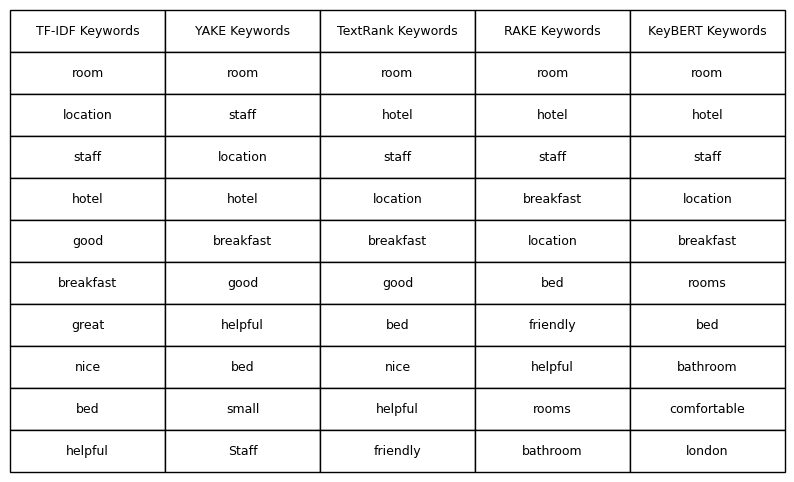

In [10]:
# Create a DataFrame for keywords from each method
num_keywords_to_display = 10
keywords_df = pd.DataFrame({
    'TF-IDF Keywords': tfidf_keywords[:num_keywords_to_display],
    'YAKE Keywords': [keyword for keyword, _ in sorted_yake_keywords][:num_keywords_to_display],
    'TextRank Keywords': [keyword for keyword, _ in sorted_textrank_keywords][:num_keywords_to_display],
    'RAKE Keywords': [keyword for keyword, _ in sorted_rake_keywords][:num_keywords_to_display],
    'KeyBERT Keywords': [keyword for keyword, _ in sorted_keybert_keywords][:num_keywords_to_display]
})

# Display keywords in a table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
ax.table(cellText=keywords_df.values, colLabels=keywords_df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

plt.show()

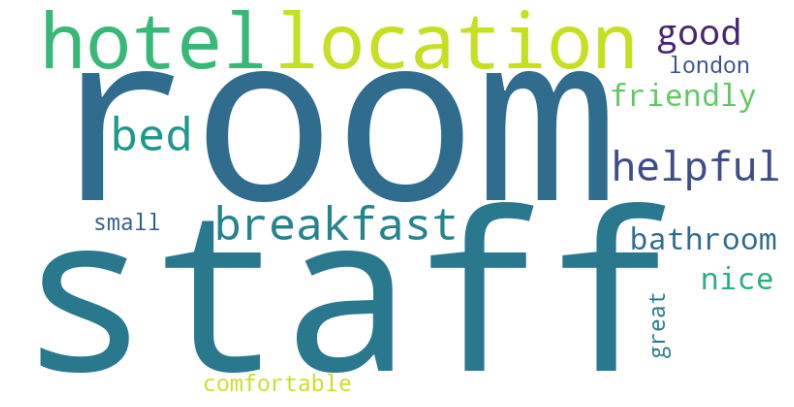

In [11]:
# Combine all keywords from each method into a single string
all_keywords = ' '.join(tfidf_keywords[:num_keywords_to_display] +
                        [keyword for keyword, _ in sorted_yake_keywords][:num_keywords_to_display] +
                        [keyword for keyword, _ in sorted_textrank_keywords][:num_keywords_to_display] +
                        [keyword for keyword, _ in sorted_rake_keywords][:num_keywords_to_display] +
                        [keyword for keyword, _ in sorted_keybert_keywords][:num_keywords_to_display])

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Evaluation

We use ROUGE metric to assess which keyword extraction method is the best, based on their similarity (F1 score) to a set of reference keywords (ground truth).

In [12]:
# Define reference keywords (ground truth)
reference_keywords = ["hotel", "service", "location", "clean", "comfortable"]

# Define extracted keywords from each method
tfidf_keywords = tfidf_keywords[:num_keywords_to_display]
yake_keywords = [keyword for keyword, _ in sorted_yake_keywords][:num_keywords_to_display]
textrank_keywords = [keyword for keyword, _ in sorted_textrank_keywords][:num_keywords_to_display]
rake_keywords = [keyword for keyword, _ in sorted_rake_keywords][:num_keywords_to_display]
keybert_keywords = [keyword for keyword, _ in sorted_keybert_keywords][:num_keywords_to_display]

# Calculate ROUGE scores
rouge = Rouge()
tfidf_scores = rouge.get_scores(' '.join(tfidf_keywords), ' '.join(reference_keywords))
yake_scores = rouge.get_scores(' '.join(yake_keywords), ' '.join(reference_keywords))
textrank_scores = rouge.get_scores(' '.join(textrank_keywords), ' '.join(reference_keywords))
rake_scores = rouge.get_scores(' '.join(rake_keywords), ' '.join(reference_keywords))
keybert_scores = rouge.get_scores(' '.join(keybert_keywords), ' '.join(reference_keywords))

# Extract F1 scores
tfidf_f1 = tfidf_scores[0]['rouge-1']['f']
yake_f1 = yake_scores[0]['rouge-1']['f']
textrank_f1 = textrank_scores[0]['rouge-1']['f']
rake_f1 = rake_scores[0]['rouge-1']['f']
keybert_f1 = keybert_scores[0]['rouge-1']['f']

# Determine the best method based on F1 score
best_method = max([
    ('TF-IDF', tfidf_f1),
    ('YAKE', yake_f1),
    ('TextRank', textrank_f1),
    ('RAKE', rake_f1),
    ('KeyBERT', keybert_f1)
], key=lambda x: x[1])

print(f"ROUGE F1 scores:")
print("TF-IDF:", tfidf_f1)
print("YAKE:", yake_f1)
print("TextRank:", textrank_f1)
print("RAKE:", rake_f1)
print("KeyBERT:", keybert_f1)
print("\nBest Method:", best_method[0])

ROUGE F1 scores:
TF-IDF: 0.2666666622222223
YAKE: 0.2666666622222223
TextRank: 0.2666666622222223
RAKE: 0.2666666622222223
KeyBERT: 0.3999999955555556

Best Method: KeyBERT


Based on the reference keywords that we defined, we can conclude that KeyBERT outperforms the other keyword extraction methods. 